# DHF - Lab 5 - Hawkes Processes in Finance

*Pierre ARTIGALA - Léon CHATAIGNAULT*
<a id='top'></a>

## Table of contents

### [1. Visual Inspection](#q1)
### [2. Systematic Analysis](#q2)


## Imports

In [1]:
import os
import numpy as np
import Hawkes as hk
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from scipy.special import kolmogorov
from datetime import datetime, time, timedelta

## Utility Functions

In [2]:
def load_trades_day(date: datetime)->pd.DataFrame:
    """Load the trades data from a given date."""
    str_date = date.strftime("%Y-%m-%d")
    file_path = "Data/RENA.PA/" + str_date + "-RENA.PA-trades.csv.gz"
    df = pd.read_csv(file_path, index_col=0)
    # Set the timestamps as index
    df.set_index("ts", drop=True, inplace=True)
    df.index = pd.to_datetime(df.index, format="%Y-%m-%d %H:%M:%S.%f")
    # Keep data from 9:30 to 17:00 only (remove 9:00-9:30 and 17:00-17:30)
    year, month, day = date.year, date.month, date.day
    start = datetime(year=year, month=month, day=day, hour=9, minute=30)
    end = datetime(year=year, month=month, day=day, hour=17, minute=0)
    return df.loc[start:end]

def load_arrival_times(day: datetime)->pd.Series:
    """Get the event times for a given day."""
    df = load_trades_day(date=day)
    # Convert the index to timestamp in seconds, starting at 0.
    df.index = df.index.values.astype(np.float64) // 10 ** 9
    df.index = df.index - df.index[0]
    # Compute the empirical durations
    trade_times = pd.Series(df.index)
    return trade_times

def reformat_arrival_times(day: datetime, reformat: str = "delete")->pd.DataFrame:
    """
    Compute arrival times and reformat them according to the input.
    "reformat" determines how jumps are handled when mutliple events occur at the same time.
    - reformat == "delete" --> delete duplicates.
    - reformat == "interpolate" --> replace duplicates by linear interpolation between the current point and the next distinct arrival time.
    """
    # Load the data
    times = load_arrival_times(day=day)
    if reformat == "delete":
        return times.drop_duplicates().reset_index(drop=True).astype(float)
    else:
        # Compute the difference and check when it is zero
        times[times.diff() == 0] = np.nan
        # Linear interpolation
        times = times.interpolate()
        return times

<a id='q1'></a>

## 1. Visual Inspection [[^]](#top)

### 1.1. Fit a Hawkes process with constant baseline intensity and exponential kernel to a trade times sample during a day.

In [3]:
def uniform_KS_test(xs, itv):
    """Kolmogorov-Smirnov test if xs is a sample drawn from a uniform distribution defined by the interval itv"""
    cdf_uni = lambda x: (x-itv[0])/(itv[1]-itv[0])
    n = len(xs)
    m = max([np.abs(k/n-cdf_uni(xs[k])) for k in range(n)])
    p_value = kolmogorov(np.sqrt(n)*m)
    return p_value

def fit_hawkes_to_trading_day(day: datetime, reformat: str = "interpolate"):
    # Load arrival times for a given day
    arrival_times = reformat_arrival_times(day=day, reformat=reformat)
    # Define the starting and ending time of the process
    itv = [0., arrival_times.iloc[-1]] # [0, T]
    # Fit a hawkes model to the sampled trade times
    model = hk.estimator()
    model.set_kernel('exp', num_exp=1)
    model.set_baseline('const')
    model.fit(arrival_times.values, itv)
    # Diagnosis plot of transformed event occurences times
    [T_trans, itv_trans] = model.t_trans()
    _, ax = plt.subplots(figsize=(6,4))
    ax.hist(T_trans)
    ax.set_title("Histogram of transformed event occurences times")
    # Kolmogorov-Smirnov test plot
    model.plot_KS()
    return T_trans, itv_trans


Reproduced KS test p-value (reformat=delete) : 0.009


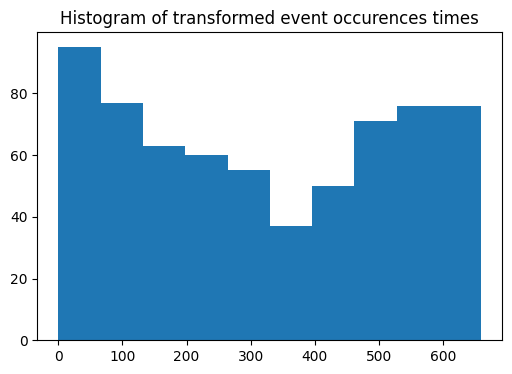

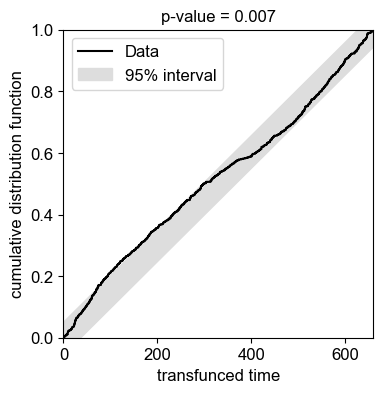

In [4]:
day = datetime(2017, 1, 2)
# "reformat" determines how jumps are handled when mutliple events occur at the same time.
reformat = "delete"

Tx, itv = fit_hawkes_to_trading_day(day=day, reformat=reformat)

print("Reproduced KS test p-value (reformat="+reformat+") :", round(uniform_KS_test(Tx, itv), 3))

Reproduced KS test p-value (reformat=interpolate) : 0.0


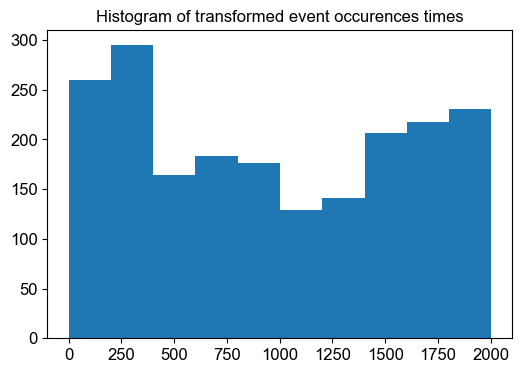

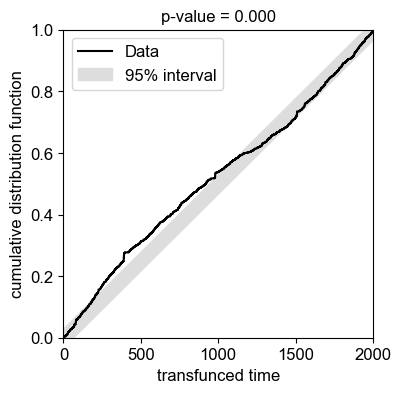

In [5]:
day = datetime(2017, 1, 2)
# "reformat" determines how jumps are handled when mutliple events occur at the same time.
reformat = "interpolate"

Tx, itv = fit_hawkes_to_trading_day(day=day, reformat=reformat)

print("Reproduced KS test p-value (reformat="+reformat+") :", round(uniform_KS_test(Tx, itv), 3))

<u>Removing duplicate jumps.</u>

When removing duplicates in case of multiple jumps occuring at the same time, the p-value is non-zero for most days, but not always above 5%. Therefore, there is some evidence against the chosen Hawkes process accurately describing trading activity.

<u>Keeping duplicate jumps.</u>

When keeping all rows from the trades dataset (and uniformly spreading duplicates when mutilple jumps occur at the same time), the p-value is consistently under 5%. So, the hypothesis of a uniform distribution is significantly rejected. The distribution of trade times during the chosen day is significantly not uniform.

<u>Note:</u> The Kolmogorov-Smirnov test coded by the team and the Hawkes package's return similar p-values, ensuring the validity of our function.

### 1.2. Try different parts of the day and different sample lengths

In [6]:
def test_hawkes_different_times_of_day(
        day:datetime,
        lenghts_minutes:list,
        starts_minutes:list,
        confidence_interval:float,
        reformat: str = "delete",
        baseline: str = "const",
        num_basis: int = 1,
        nb_kernels: int = 1
        )->pd.DataFrame:
    """ 
    Fits a Hawkes process with constant baseline intensity and a single exponential kernel with MLE.
    The fits are realized for different time intervals accros the day (starts_minutes x lengths_minutes).
    Returns the AIC of each combination between 9:30am and 5:00pm.
    """
    # Shift the start of the day to 9am (markets opening)
    day = datetime(year=day.year, month=day.month, day=day.day, hour=9)
    # Load trade times of given day
    times = reformat_arrival_times(day=day, reformat=reformat)
    # Initialise results
    res = pd.DataFrame(dtype=float, columns=["Start Time", "End Time", "AIC", "p value", "Significantly Rejected", "branching_ratio"])
    # Computation loop on each combination
    n = 0
    for x in lenghts_minutes:
        span = timedelta(minutes=x)
        for s in starts_minutes:
            start_time = day + timedelta(minutes=s)
            start_stamp = start_time.timestamp()-day.timestamp()
            end_time = start_time + span
            # Test if the span is included in trading hours of the day
            if (end_time.time() < time(hour=17, minute=30)) and (start_time.time() < time(hour=17, minute=30)) and (end_time.day == day.day):
                end_stamp = (start_time+span).timestamp() - day.timestamp()
                sampled_times = times.loc[times.between(start_stamp, end_stamp)]
                itv = [start_stamp, end_stamp] # [0, T]
                # Fit a hawkes model to the sampled trade times
                model = hk.estimator()
                model.set_kernel('exp', num_exp=nb_kernels)
                if baseline == "const":
                    model.set_baseline(baseline)
                else:
                    model.set_baseline(baseline, num_basis=num_basis)
                model.fit(sampled_times.values, itv)
                [T_trans, itv_trans] = model.t_trans()
                # Perform the Kolmogorov-Smirnov test on the transformed event occurrence times.
                # H0: "These event times follow a uniform distribution."
                p_value = uniform_KS_test(T_trans, itv_trans)
                res.loc[n] = {"Start Time": start_time, "End Time": end_time, "AIC":model.AIC, 
                              "p value": p_value, "Significantly Rejected": p_value<confidence_interval,
                              "branching_ratio": model.br}
                n += 1
    # Format result table
    res["Timespan"] = res["End Time"] - res["Start Time"]
    res = res.set_index(["Start Time", "End Time"])
    res.sort_values(by="AIC")
    return res


def plot_AICs(AICs:pd.DataFrame, ax=None):
    """Plot AIC values computed for the different time windows across the day (in log-scale)."""
    day = AICs.index.get_level_values(level="Start Time")[0]
    if ax is None:
        _, ax = plt.subplots(figsize=(12,8))
    ax.hlines(y=AICs.values, xmin=AICs.index.get_level_values("Start Time"), xmax=AICs.index.get_level_values("End Time"))
    ax.set_yscale("log")
    ax.set_title("Computed AIC for different timespans ({})".format(day.strftime(format="%Y-%m-%d")))
    ax.set_xlabel("Sampled period of the day")
    ax.set_ylabel("AIC")
    return ax


def color_bin(val:bool):
    if val:
        return "red"
    return "green"


def plot_p_values(p_values:pd.DataFrame, ax=None):
    """Plot p-values computed for the different time windows across the day (in log-scale)."""
    day = p_values.index.get_level_values(level="Start Time")[0]
    if ax is None:
        _, ax = plt.subplots(figsize=(12,8))
    colors=["green", "red"]
    ax.hlines(
        y=p_values["p value"].values, 
        xmin=p_values.index.get_level_values("Start Time"), 
        xmax=p_values.index.get_level_values("End Time"),
        colors=p_values["Significantly Rejected"].apply(color_bin).values
        )
    legend_elements = [Patch(facecolor=color, edgecolor='w') for color in colors]
    ax.legend(handles=legend_elements,
            labels=["Not Rejected", "Rejected Hawkes hypothesis"])
    ax.set_yscale("log")
    ax.set_title("p values and rejected status for different timespans ({})".format(day.strftime(format="%Y-%m-%d")))
    ax.set_xlabel("Sampled period of the day")
    ax.set_ylabel("p value")
    return ax


def plot_AIC_p_values(
        day:datetime,
        lenghts_minutes:list,
        starts_minutes:list,
        confidence_interval:float,
        reformat: str = "delete"
    ):
    """Plot the AIC and p-values for different time windows."""
    # Compute the results
    res = test_hawkes_different_times_of_day(
        day=day,
        lenghts_minutes=lenghts_minutes,
        starts_minutes=starts_minutes,
        confidence_interval=confidence_interval,
        reformat=reformat
    )
    AICs = res[["AIC"]]
    p_values = res[["p value", "Significantly Rejected"]]
    # Plot
    fig, axs = plt.subplots(ncols=2, figsize=(20,8))
    _ = plot_AICs(AICs, ax=axs[0])
    _ = plot_p_values(p_values, ax=axs[1])
    # Figure title
    str_date = day.strftime(format="%Y-%m-%d")
    str_title = "Hawkes model analysis (" + str_date + ", reformat=" + reformat + ")"
    fig.suptitle(str_title)
    return res


def to_time(td:timedelta)->time:
    return time(hour=td.seconds//3600, minute=(td.seconds//60)%60)


def test_stats(
    day:datetime,
    lenghts_minutes:list,
    starts_minutes:list,
    confidence_interval:float,
    reformat: str = "delete"
):
    """For a given time window length (in minutes), compute the proportion of samples passing the uniformity hypothesis test."""
    # Compute the results
    res = test_hawkes_different_times_of_day(
        day=day,
        lenghts_minutes=lenghts_minutes,
        starts_minutes=starts_minutes,
        confidence_interval=confidence_interval,
        reformat=reformat
    )
    success_frequency = pd.DataFrame(dtype=float, columns=["Frequency of passing the test"])
    success_frequency["Frequency of passing the test"] = res.loc[res["Significantly Rejected"]==False]\
        ["Timespan"].value_counts()/res["Timespan"].value_counts()
    success_frequency.index = pd.Series(success_frequency.index).apply(to_time)
    success_frequency.index.name = "Time itv"
    return success_frequency.fillna(0)

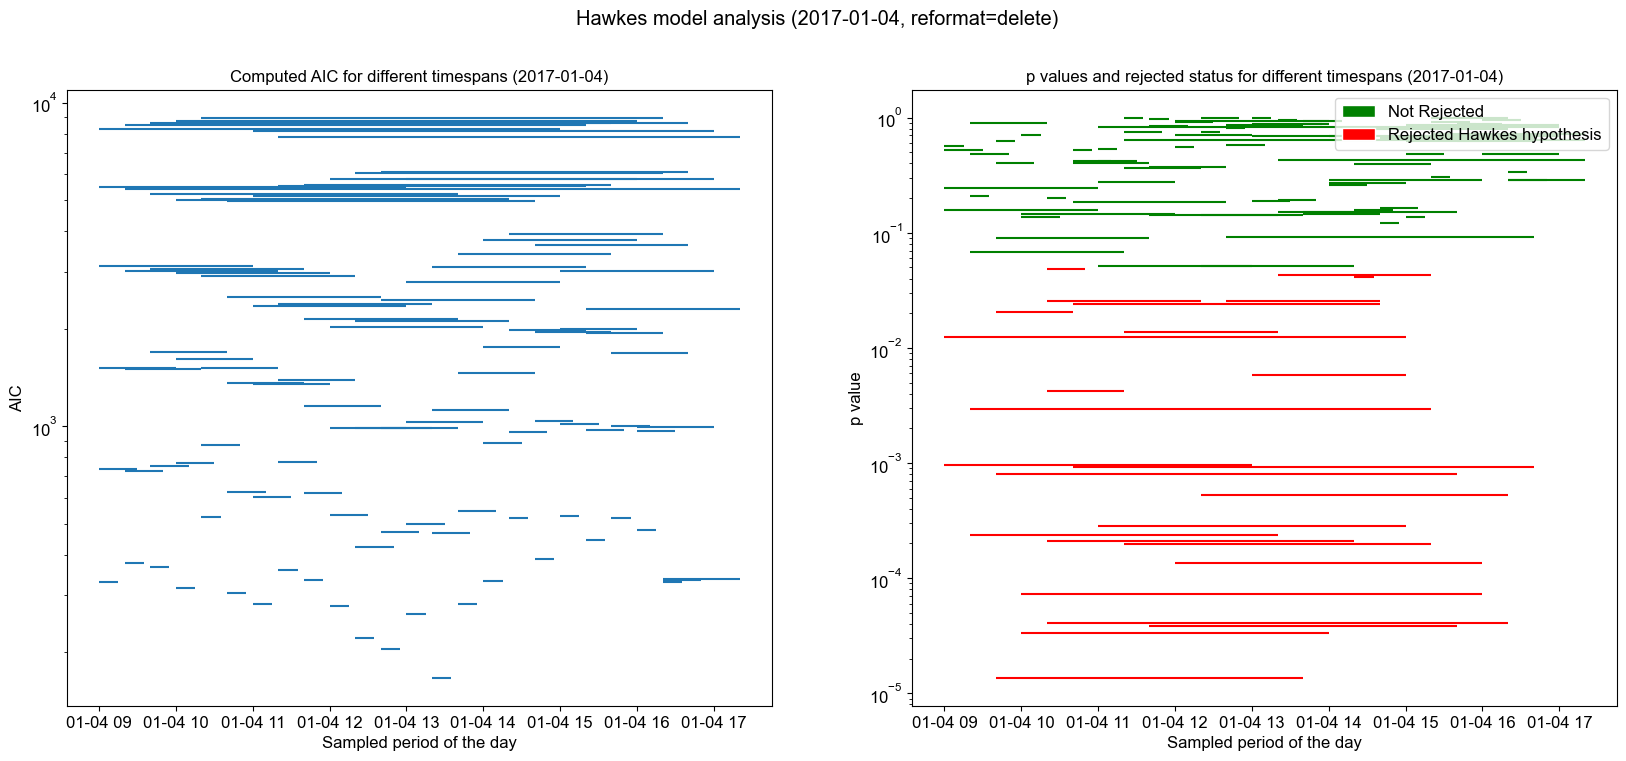

In [7]:
day = datetime(2017, 1, 4)
lenghts_minutes = [15, 30, 60, 120, 240, 360]
starts_minutes = range(0, 451, 20)
confidence_interval = 0.05
reformat = "delete"

res = plot_AIC_p_values(
    day=day,
    lenghts_minutes=lenghts_minutes,
    starts_minutes=starts_minutes,
    confidence_interval=confidence_interval,
    reformat=reformat
)

In [8]:
success_frequencies = test_stats(
    day=day,
    lenghts_minutes=lenghts_minutes,
    starts_minutes=starts_minutes,
    confidence_interval=confidence_interval,
    reformat=reformat
)
success_frequencies

,Frequency of passing the test
Time itv,
00:15:00,0.956522
00:30:00,0.956522
01:00:00,0.913043
02:00:00,0.750000
04:00:00,0.214286
06:00:00,0.250000


In [9]:
# Timespans which uniformity test has not been rejected (top 10 p-values):
res.loc[res["Significantly Rejected"]==False].sort_values(by="p value", ascending=False).head(10)

,,AIC,p value,Significantly Rejected,branching_ratio,Timespan
Start Time,End Time,,,,,
2017-01-04 13:00:00,2017-01-04 13:15:00,263.235739,0.999743,False,1.440791e-08,0 days 00:15:00
2017-01-04 11:20:00,2017-01-04 11:35:00,358.128500,0.996227,False,9.659794e-02,0 days 00:15:00
2017-01-04 12:20:00,2017-01-04 12:50:00,423.214809,0.996043,False,1.201287e-01,0 days 00:30:00
2017-01-04 15:20:00,2017-01-04 16:20:00,1945.244569,0.993372,False,2.825035e-01,0 days 01:00:00
2017-01-04 11:40:00,2017-01-04 11:55:00,333.887823,0.965511,False,3.949469e-01,0 days 00:15:00
2017-01-04 13:20:00,2017-01-04 13:35:00,166.953795,0.956391,False,4.370621e-06,0 days 00:15:00
2017-01-04 16:00:00,2017-01-04 16:30:00,964.197471,0.953741,False,2.711809e-01,0 days 00:30:00
2017-01-04 12:00:00,2017-01-04 14:00:00,2024.122502,0.943770,False,1.266460e-01,0 days 02:00:00
2017-01-04 13:40:00,2017-01-04 14:10:00,544.610291,0.936751,False,2.426486e-01,0 days 00:30:00


<b><u>Comments.</b></u>

The AIC values are generally smaller for shorter timespans : Hawkes model fits better on short periods of time intraday. 

This is confirmed by the fact that the frequency of null hypothesis rejection increases as the timespan increases. The proportion of samples passing the Kolmogorov-Smirnov test is a decreasing function of the timespan.

There is a noticeable better fit for the Hawkes process around noon, regardless of the length of time tested.

<b><u>Conclusion:</u> The Hawkes model with a constant baseline intensity and a kernel with one exponential is more adapted to shorter timespans.</b>

<a id='q2'></a>

## 2. Systematic Analysis [[^]](#top)

### 2.1. Fit a Hawkes process for different baseline functions, varying number of exponential kernels and different sample sizes for each day.

In [10]:
# List of parameter combinations that do not work (runtime error when training the model on these combinations)
L_EXCEPTIONS = [
    [datetime(2017, 1, 17, 0, 0), 8, 'plinear'],
    [datetime(2017, 1, 24, 0, 0), 4, 'plinear'],
    [datetime(2017, 1, 30, 0, 0), 4, 'plinear'],
]

def systematic_one_day(
    day: datetime,
    lenghts_minutes: list,
    starts_minutes: list,
    confidence_interval: float,
    reformat: str = "delete",
    baseline: str = "const",
    num_basis: int = 1,
    nb_kernels: int = 1
):
    """
    Fit a Hawkes model on a given day, for a given baseline function, number of exponential kernels
    and sample windows within that day. Compute AIC and p-value (of Kolmogorov-Smirnov test) for each model.
    - day: datetime
    - sample_windows: defined by lists starts_minutes (starting points within the day) and lenghts_minutes (intervals' lengths)
    - confidence_interval: rejection threshold in the KS test
    - baseline: "const" (constant), "plinear" (piecewise linear baseline, need to specify "num_basis")
    - nb_kernels: int
    - reformat: determines how jumps are handled when mutliple events occur at the same time.
    """
    # Compute the results
    res = test_hawkes_different_times_of_day(
        day=day,
        lenghts_minutes=lenghts_minutes,
        starts_minutes=starts_minutes,
        confidence_interval=confidence_interval,
        reformat=reformat,
        baseline=baseline,
        num_basis=num_basis,
        nb_kernels=nb_kernels
    )

    # Add columns with the baseline type, number of basis (=1 if baseline="const")
    res["baseline"] = baseline
    if baseline == "const":
        res["num_basis"] = 1
    else:
        res["num_basis"] = num_basis
    # Add a column with the number of exponential kernels
    res["nb_kernels"] = nb_kernels
    # Add a column with the reformatting method used ("delete" or "interpolate")
    res["reformat"] = reformat
    # Add a column with the date
    res["Date"] = day
    return res.reset_index()


def get_list_files(start_date: datetime, end_date: datetime):
    """Get the list of file dates between start_date and end_date."""
    # Keep only the dates from the datetimes
    start_date = start_date.date()
    end_date = end_date.date()
    # List of files to be loaded
    l_files = os.listdir("Data/RENA.PA/")
    l_dates = []
    for file in l_files:
        # Keep the files with the correct suffix
        if str(file).split(".")[-3].endswith("trades"):
            # Get the date for this file
            date_file = str(file).split(".")[0][:-5]
            # Convert it to datetime
            date_file = datetime.strptime(date_file, "%Y-%m-%d")
            # Keep the files that are between start_date and end_date
            if start_date <= date_file.date() <= end_date:
                l_dates.append(date_file)
    return sorted(l_dates)


def load_results_analysis():
    """Load the results from the systematic analysis."""
    try:
        df = pd.read_csv("results.csv")
        # Convert to datetime columns
        df['Start Time']= pd.to_datetime(df['Start Time'])
        df['End Time']= pd.to_datetime(df['End Time'])
        df['Date']= pd.to_datetime(df['Date'])
        return df
    except:
        return pd.DataFrame()


def check_params(
    day: datetime,
    baseline: str,
    num_basis: int,
    nb_kernels: int,
    reformat: str
):
    """Check if the (day, baseline, num_basis, nb_kernel, reformat) already exists in the dataframe."""
    # Load the data
    df = load_results_analysis()
    if len(df) == 0:
        return False
    # Check if this set of parameters has already been used
    elif len(df.loc[(df["Date"]==day) &
        (df["baseline"]==baseline) &
        (df["num_basis"]==num_basis) &
        (df["nb_kernels"]==nb_kernels) &
        (df["reformat"]==reformat)
        ]) == 0:
        return False
    else:
        return True


def systematic_analysis(
    start_date: datetime,   
    end_date: datetime,
    lenghts_minutes: list,
    starts_minutes: list,
    confidence_interval: float,
    l_reformat: list = ["delete"],
    l_baseline: list = ["const", "plinear"],
    l_num_basis: list = [10],
    l_nb_kernels: list = [1, 2, 4]
):
    """Get the systematic analysis metrics for all the dates between start_date and end_date, and all the parameters combinations."""
    # Get the list of dates for which data must be collected
    l_dates = get_list_files(start_date=start_date, end_date=end_date)
    for day in l_dates:
        for nb_kernels in l_nb_kernels:
            for baseline in l_baseline:
                # Skip exceptions
                if [day, nb_kernels, baseline] in L_EXCEPTIONS:
                    continue
                for num_basis in l_num_basis:
                    # Change the number of basis to 1 if the baseline is constant
                    if baseline == "const":
                        num_basis = 1
                    for reformat in l_reformat:
                        # Load the data in cache
                        df = load_results_analysis()
                        # Check if this set of parameters has already been calculated
                        already_calculated = check_params(
                            day=day,
                            reformat=reformat,
                            baseline=baseline,
                            num_basis=num_basis,
                            nb_kernels=nb_kernels
                        )
                        if not already_calculated:
                            temp = systematic_one_day(
                            day=day,
                            lenghts_minutes=lenghts_minutes,
                            starts_minutes=starts_minutes,
                            confidence_interval=confidence_interval,
                            reformat=reformat,
                            baseline=baseline,
                            num_basis=num_basis,
                            nb_kernels=nb_kernels
                            )
                            # Concatenate the dataframes
                            df = pd.concat([df, temp], axis=0)
                            # Update the .csv file
                            df.to_csv("results.csv", index=False)
    return df

In [11]:
start_date = datetime(2017, 1, 1)
end_date = datetime(2017, 2, 1)
lenghts_minutes = [15, 30, 60, 120, 240, 360]
starts_minutes = range(0, 451, 20)
confidence_interval = 0.05
l_reformat = ["delete"]
l_baseline = ["const", "plinear"]
l_num_basis = [10]
l_nb_kernels = [1, 2, 4, 8]

df = systematic_analysis(
    start_date=start_date,
    end_date=end_date,
    lenghts_minutes=lenghts_minutes,
    starts_minutes=starts_minutes,
    confidence_interval=confidence_interval,
    l_reformat=l_reformat,
    l_baseline=l_baseline,
    l_num_basis=l_num_basis,
    l_nb_kernels=l_nb_kernels
)

### Load the results of the systematic analysis

In [12]:
df = load_results_analysis()
df

,Start Time,End Time,AIC,p value,Significantly Rejected,branching_ratio,Timespan,baseline,num_basis,nb_kernels,reformat,Date
0,2017-01-02 09:00:00,2017-01-02 09:15:00,259.020265,0.252177,False,1.535101e-01,0 days 00:15:00,const,1,1,delete,2017-01-02
1,2017-01-02 09:20:00,2017-01-02 09:35:00,431.831145,0.938645,False,1.430070e+06,0 days 00:15:00,const,1,1,delete,2017-01-02
2,2017-01-02 09:40:00,2017-01-02 09:55:00,242.303509,0.995778,False,1.511586e-03,0 days 00:15:00,const,1,1,delete,2017-01-02
3,2017-01-02 10:00:00,2017-01-02 10:15:00,190.280600,0.994280,False,6.528682e-02,0 days 00:15:00,const,1,1,delete,2017-01-02
4,2017-01-02 10:20:00,2017-01-02 10:35:00,189.768544,0.472441,False,1.034878e-01,0 days 00:15:00,const,1,1,delete,2017-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...
19198,2017-01-31 10:00:00,2017-01-31 16:00:00,11640.380235,0.994027,False,2.887704e-01,0 days 06:00:00,plinear,10,8,delete,2017-01-31
19199,2017-01-31 10:20:00,2017-01-31 16:20:00,12157.353961,0.999322,False,2.730019e-01,0 days 06:00:00,plinear,10,8,delete,2017-01-31
19200,2017-01-31 10:40:00,2017-01-31 16:40:00,12106.628919,0.781734,False,5.009005e-01,0 days 06:00:00,plinear,10,8,delete,2017-01-31
19201,2017-01-31 11:00:00,2017-01-31 17:00:00,11511.198415,0.144210,False,7.112484e-01,0 days 06:00:00,plinear,10,8,delete,2017-01-31


### 2.2. How frequently is a statistical test of goodness-of-fit passed?

In [13]:
def proportion_goodness_of_fit(l_params: list):
    """
    Compute the proportion of KS tests passed per parameters combination.
    - l_params : Parameters to use for the groupby (Timespan, baseline, num_basis, nb_kernels, reformat).
    """
    # Load the results of the systematic analysis
    df = load_results_analysis()
    # Keep only the relevant columns
    l_cols = ["Significantly Rejected"] + l_params
    df = df[l_cols]
    # Group by "Timespan" (sample length) and compute the average proportion of tests passed
    df_passed = 1 - df.groupby(l_params).mean()["Significantly Rejected"]
    df_passed.name = "pct_passed"
    return df_passed.to_frame()

In [14]:
# Parameters to use for the groupby (Timespan, baseline, num_basis, nb_kernels, reformat)
l_params = ["Timespan"]

df_passed = proportion_goodness_of_fit(l_params=l_params)
df_passed

,pct_passed
Timespan,
0 days 00:15:00,0.982408
0 days 00:30:00,0.965067
0 days 01:00:00,0.939432
0 days 02:00:00,0.874855
0 days 04:00:00,0.730388
0 days 06:00:00,0.760116


In [15]:
# Parameters to use for the groupby (Timespan, baseline, num_basis, nb_kernels, reformat)
l_params = ["Timespan", "baseline"]

df_passed = proportion_goodness_of_fit(l_params=l_params)
df_passed

pct_passed
Timespan        baseline            
0 days 00:15:00 const       0.965415
                plinear     1.000000
0 days 00:30:00 const       0.931324
                plinear     1.000000
0 days 01:00:00 const       0.880929
                plinear     1.000000
0 days 02:00:00 const       0.753977
                plinear     1.000000
0 days 04:00:00 const       0.476461
                plinear     0.993277
0 days 06:00:00 const       0.563920
                plinear     0.963235

<b><u>Comments.</b></u>

As previously seen, the proportion of samples passing the goodness-of-fit test decreases with larger sample lengths. When looking at the proportion as a function of the type of baseline used, it can be seen that it decreases only with constant baselines. With a piecewise linear baseline, almost all samples pass the test.

### 2.3. [6] finds that statistical significance in high-frequency requires multiple exponential kernels for datasets of several hours. Is this in line with your observations ?

[6] Mehdi Lallouache and Damien Challet. “The limits of statistical significance of Hawkes processes fitted to financial data”. In: Quantitative Finance 16.1 (2016), pp. 1–11.

In [16]:
# Parameters to use for the groupby (Timespan, baseline, num_basis, nb_kernels, reformat)
l_params = ["Timespan", "nb_kernels"]

df_passed = proportion_goodness_of_fit(l_params=l_params)
df_passed

pct_passed
Timespan        nb_kernels            
0 days 00:15:00 1             0.981225
                2             0.982213
                4             0.982402
                8             0.983822
0 days 00:30:00 1             0.956522
                2             0.964427
                4             0.968944
                8             0.970677
0 days 01:00:00 1             0.920949
                2             0.941700
                4             0.945135
                8             0.950455
0 days 02:00:00 1             0.831818
                2             0.871591
                4             0.894048
                8             0.903488
0 days 04:00:00 1             0.668831
                2             0.735390
                4             0.753401
                8             0.765781
0 days 06:00:00 1             0.636364
                2             0.784091
                4             0.803571
                8             0.819767

<b><u>Comments.</b></u>

For short dataset lengths (<1h), the number of kernels does not influence the goodness-of-fit results. Indeed, the latter is close to one even with only one exponential kernel. However, when considering longer dataset (>1h), the goodness-of-fit decreases for a given number of kernels. In these cases, increasing the number of kernels increases the accuracy of the models.

Therefore, the findings in [6] are in line with our observations.

### 2.4. Analyze the median branching ratios per sample length, baseline and exponential.

In [17]:
def median_branching_ratio(l_params: list):
    """
    Compute the median branching ratio per parameters combination
    - l_params : Parameters to use for the groupby (Timespan, baseline, num_basis, nb_kernels, reformat).
    """
    # Load the results of the systematic analysis
    df = load_results_analysis()
    # Keep only the relevant columns
    l_cols = ["branching_ratio"] + l_params
    df = df[l_cols]
    # Group by "Timespan" (sample length) and compute the average proportion of tests passed
    df_br = 1 - df.groupby(l_params).median()["branching_ratio"]
    df_br.name = "median_br"
    return df_br.to_frame()

In [18]:
l_params = ["Timespan"]

df_br = median_branching_ratio(l_params=l_params)
df_br

,median_br
Timespan,
0 days 00:15:00,0.908831
0 days 00:30:00,0.837703
0 days 01:00:00,0.752780
0 days 02:00:00,0.615959
0 days 04:00:00,0.471278
0 days 06:00:00,0.341160


In [19]:
l_params = ["baseline", "num_basis"]

df_br = median_branching_ratio(l_params=l_params)
df_br

,,median_br
baseline,num_basis,
const,1,0.639972
plinear,10,0.830536


In [20]:
l_params = ["nb_kernels"]

df_br = median_branching_ratio(l_params=l_params)
df_br

,median_br
nb_kernels,
1,0.795885
2,0.749588
4,0.689006
8,0.666179


<b><u>Comments.</b></u>

The branching ratio can be seen as a measurement of whether the process is endogenous or exogenous. It is defined by the average number of first generation jumps steming from the self-excitation of a single jump. 

When the branching ratio is null, the process in exogenous and can be identified as a non-homogenous poisson process.

When the branching ratio approaches the critical value 1, the underlying process is more and more endogenous (self-exctiting).

It can be observed that the process's self-exciting property increases at smaller time scales. Indeed, at high frequency (short time windows), an agent's strategy is based on other traders' actions, leading to self excitation of the trade process. 

The fact that the branching ratio is higher when fitting a piecewise linear baseline can be due to the underestimation of the constant baseline fit during trading intensity outbursts.

Decreasing the number of kernels decreases the branching ratio. Using more kernels allows to account for short and long-term self-exciting processes separately (different $\beta$ values). With fewer kernels, the fit tends to yield higher branching ratios as it is attracted towards high bursts in activity.

### 2.5. Analyze the median number of exponentials selected by AIC per sample length and baseline.

In [25]:
def median_nb_kernels():
    """Compute the median number of kernels selected by AIC per sample length and baseline."""
    # Load the results of the systematic analysis
    df = load_results_analysis()
    # Keep the relevant columns only
    l_cols_keep = ['Start Time', 'End Time', 'Timespan', 'baseline', 'num_basis', 'nb_kernels', 'reformat', "AIC"]
    df = df[l_cols_keep]
    # Find the nb_kernels corresponding to the lowest AIC for each sample and combination of parameters (excluding nb_kernels)
    l_cols_groupby = ['Start Time', 'End Time', 'Timespan', 'baseline', 'num_basis', 'reformat', "AIC"]
    df_aic = df.loc[df.groupby(l_cols_groupby)['AIC'].idxmin()]
    # Compute the median nb_kernels per sample length and baseline
    l_cols_keep = ['Timespan', 'baseline', 'num_basis', 'nb_kernels']
    df_aic_median = df_aic.groupby(["Timespan", "baseline", "num_basis"]).median(numeric_only=True)["nb_kernels"]
    df_aic_mean = df_aic.groupby(["Timespan", "baseline", "num_basis"]).mean(numeric_only=True)["nb_kernels"]
    df_aic_median.name = "median_nb_kernels"
    df_aic_median = df_aic_median.to_frame()
    df_aic_median["mean_nb_kernels"] = df_aic_mean
    return df_aic_median

In [26]:
df_aic = median_nb_kernels()
df_aic

median_nb_kernels  mean_nb_kernels
Timespan        baseline num_basis                                    
0 days 00:15:00 const    1                        4.0         3.761477
                plinear  10                       2.0         3.694118
0 days 00:30:00 const    1                        2.0         3.755925
                plinear  10                       2.0         3.695541
0 days 01:00:00 const    1                        2.0         3.763117
                plinear  10                       2.0         3.693105
0 days 02:00:00 const    1                        2.0         3.722494
                plinear  10                       2.0         3.708232
0 days 04:00:00 const    1                        2.0         3.586269
                plinear  10                       2.0         3.689625
0 days 06:00:00 const    1                        2.0         3.308901
                plinear  10                       2.0         3.591125

<b><u>Comments.</b></u>

The optimal number of exponential kernels decreases as the timespan increases for each baseline category. At long time scales, one short-memory and one long-memory kernels capture all the trading activity. Conversely, for shorter timespans, self-excitement effects are more complex and therefore more reaction lags have to been accounted for in the model.